## Info what use this notebook
https://www.kaggle.com/code/aliazimieco/forex-price-prediction-binary-classification-mode
https://medium.com/@dbhatt245/mastering-lstm-networks-for-text-classification-from-simple-sentiment-models-to-cnn-lstm-hybrids-00d93a131c28
https://medium.com/@jain.sm/hybrid-lstm-snn-model-for-stock-price-prediction-a-deep-dive-into-neural-network-fusion-012bd5fba7fc
https://medium.com/@moneytent/this-ai-forex-trading-strategy-will-make-you-rich-with-chat-gpt-4843132570d1
https://www.kaggle.com/code/hansmens/price-direction-prediction-eurusd-forex-pair
https://www.kaggle.com/code/muhammadqasimshabbir/lb0-9727-lgb-binaryclassificationwithbankdataset
https://capital.com/ru-int/learn/technical-analysis/fibonacci-retracement-strategy



In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import yfinance as yf
import ta

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                            mean_absolute_error, mean_squared_error, r2_score, 
                            mean_absolute_percentage_error)

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression, LinearRegression
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier, CatBoostRegressor

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [14, 8]
plt.rcParams['font.size'] = 12

2025-12-20 21:54:11.413673: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-20 21:54:11.428018: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-20 21:54:11.442676: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-20 21:54:11.446521: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-20 21:54:11.458532: I tensorflow/core/platform/cpu_feature_guar

In [2]:

ticker = 'USDJPY=X'
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365) 


df = yf.download(ticker, start=start_date, end=end_date, interval='1d', progress=False)

print(f"Download data: {df.shape[0]}\n\n")
print(len(df.shape))
print("periods:", df.index.min() - df.index.max()) 

Download data: 1303


2
periods: -1825 days +00:00:00


<center><font centor size = 8 color='green'>EDA

In [3]:
df.head(5)

Price,Close,High,Low,Open,Volume
Ticker,USDJPY=X,USDJPY=X,USDJPY=X,USDJPY=X,USDJPY=X
Date,,,,,
2020-12-21,103.457001,103.885002,103.257004,103.473000,0
2020-12-22,103.339996,103.722000,103.278999,103.336998,0
2020-12-23,103.533997,103.635002,103.362999,103.527000,0
2020-12-24,103.552002,103.755997,103.500000,103.525002,0
2020-12-25,103.653000,103.654999,103.213997,103.621002,0


In [4]:
df.tail(5)

Price,Close,High,Low,Open,Volume
Ticker,USDJPY=X,USDJPY=X,USDJPY=X,USDJPY=X,USDJPY=X
Date,,,,,
2025-12-16,155.014999,155.110992,154.470001,155.024002,0
2025-12-17,154.778000,155.626999,154.514008,154.768005,0
2025-12-18,155.494995,155.964996,155.289001,155.479996,0
2025-12-19,155.585999,157.487000,155.567993,155.567993,0
2025-12-20,157.750000,157.750000,157.750000,157.750000,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1303 entries, 2020-12-21 to 2025-12-20
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   (Close, USDJPY=X)   1303 non-null   float64
 1   (High, USDJPY=X)    1303 non-null   float64
 2   (Low, USDJPY=X)     1303 non-null   float64
 3   (Open, USDJPY=X)    1303 non-null   float64
 4   (Volume, USDJPY=X)  1303 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 61.1 KB


In [6]:
df.describe()

Price,Close,High,Low,Open,Volume
Ticker,USDJPY=X,USDJPY=X,USDJPY=X,USDJPY=X,USDJPY=X
count,1303.000000,1303.000000,1303.000000,1303.000000,1303.0
mean,136.227969,136.739743,135.689213,136.226909,0.0
std,16.661229,16.759511,16.519335,16.660327,0.0
min,102.678001,103.180000,102.589996,102.699997,0.0
25%,119.428501,120.182499,119.347000,119.427502,0.0
50%,142.595993,143.356003,141.914993,142.595993,0.0
75%,149.160004,149.564003,148.527000,149.160004,0.0
max,161.621002,161.942001,161.300003,161.621002,0.0


<font centor size = 5 color='red'>Indicators Append

In [7]:

df = df.copy()

if isinstance(df['Close'], pd.DataFrame): 
    close_series = df['Close'].squeeze()
else: 
    close_series = df['Close']

ema_periods = [8, 13, 21, 34, 55, 100]
for period in ema_periods: 
    df[f'EMA_{period}'] = close_series.ewm(span=period).mean()

print(f'Append:{len(ema_periods)} Ema indicators')


Append:6 Ema indicators


In [8]:
#fibonachi
df['High_20'] = df['High'].rolling(window=20).max()
df['Low_20'] = df['Low'].rolling(window=20).min()

fib_levels = [0.236, 0.382, 0.5, 0.628, 0.786]
for level in fib_levels:
    df[f'Fib_{level}'] = df['Low_20'] + (df['High_20'] - df['Low_20']) * level

print(f"Append {len(fib_levels)} fibonachi levels")

Append 5 fibonachi levels


In [9]:
delta = close_series.diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

exp1 = close_series.ewm(span=12).mean()
exp2 = close_series.ewm(span=26).mean()
df['MACD'] = exp1 - exp2
df['MACD_signal'] = df['MACD'].ewm(span=9).mean()
df['MACD_diff'] = df['MACD'] - df['MACD_signal']

print("Append RSI and MACD")

Append RSI and MACD


In [10]:

df['Returns'] = close_series.pct_change()

df['DayOfWeek'] = df.index.dayofweek
df['Month'] = df.index.month
df['WeekOfYear'] = df.index.isocalendar().week

df['Future_Price_7d'] = close_series.shift(-7)
df['Future_Return_7d'] = (df['Future_Price_7d'] - close_series) / close_series

percentiles = df['Future_Return_7d'].quantile([0.33, 0.66]).values

df['Target_Class'] = 0  # netral
df.loc[df['Future_Return_7d'] < percentiles[0], 'Target_Class'] = -1  # SELL
df.loc[df['Future_Return_7d'] > percentiles[1], 'Target_Class'] = 1   # BUY

df['Target_Reg'] = df['Future_Price_7d']


In [11]:
df = df.dropna()
print(f'Create: {len(df.columns)} features')

Create: 30 features


In [12]:
df.head(5)

Price,Close,High,Low,Open,Volume,EMA_8,EMA_13,EMA_21,EMA_34,EMA_55,...,MACD_signal,MACD_diff,Returns,DayOfWeek,Month,WeekOfYear,Future_Price_7d,Future_Return_7d,Target_Class,Target_Reg
Ticker,USDJPY=X,USDJPY=X,USDJPY=X,USDJPY=X,USDJPY=X,,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-15,103.828003,103.885002,103.620003,103.836998,0,103.719300,103.638965,103.583788,103.551221,103.532988,...,0.033869,0.049864,-0.000087,4,1,2,103.760002,-0.000655,0,103.760002
2021-01-18,103.907997,103.922997,103.639000,103.912003,0,103.761448,103.678969,103.617867,103.579962,103.558065,...,0.045808,0.047203,0.000770,0,1,3,103.602997,-0.002935,-1,103.602997
2021-01-19,103.703003,104.082001,103.650002,103.695999,0,103.748408,103.682522,103.626690,103.589647,103.567465,...,0.053772,0.031563,-0.001973,1,1,3,104.142998,0.004243,0,104.142998
2021-01-20,103.897003,103.917999,103.462997,103.898003,0,103.781531,103.714073,103.654354,103.613329,103.588230,...,0.061372,0.030177,0.001871,2,1,3,104.291000,0.003792,0,104.291000
2021-01-21,103.555000,103.658997,103.325996,103.556999,0,103.731070,103.690772,103.644301,103.608922,103.586192,...,0.063465,0.008320,-0.003292,3,1,3,104.685997,0.010922,1,104.685997


<font centor size = 5 color='red'>Target_check

In [13]:
class_counts = df['Target_Class'].value_counts().sort_index()

for cls, count in class_counts.items(): 
    label = 'SELL' if cls == -1 else 'HOLD' if cls == 0 else 'BUY'
    print(f"{label}: {count} ({count/len(df):.1%})")

print(f" Mean: {df['Future_Return_7d'].mean():.2%}")
print(f"std: {df['Future_Return_7d']}")


SELL: 420 (32.9%)
HOLD: 420 (32.9%)
BUY: 437 (34.2%)
 Mean: 0.23%
std: Date
2021-01-15   -0.000655
2021-01-18   -0.002935
2021-01-19    0.004243
2021-01-20    0.003792
2021-01-21    0.010922
                ...   
2025-12-05   -0.000819
2025-12-08   -0.003618
2025-12-09   -0.002239
2025-12-10   -0.007983
2025-12-11    0.012581
Name: Future_Return_7d, Length: 1277, dtype: float64


The dependent variable contains  3  unique labels: [ 0 -1  1]

Percentage of "0" labels: 32.89%
Percentage of "-1" labels: 32.89%
Percentage of "1" labels: 34.22%


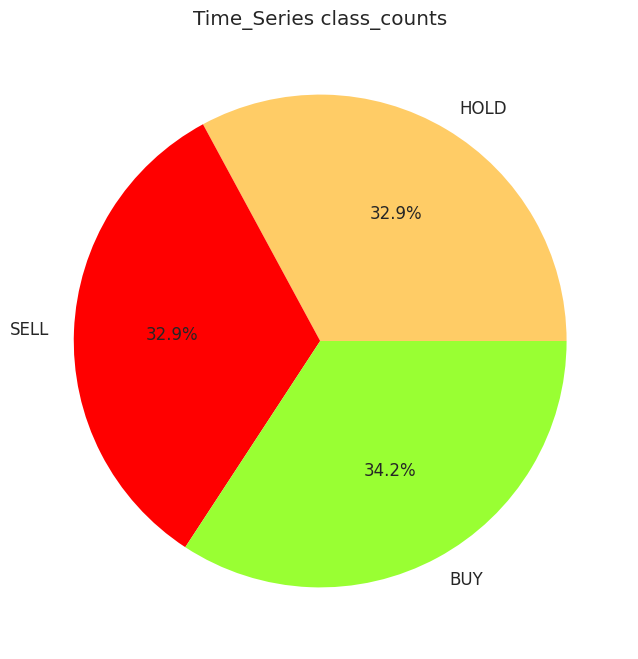

In [14]:
print('The dependent variable contains ', len(df['Target_Class'].unique()), ' unique labels:', df['Target_Class'].unique())

print('\nPercentage of "0" labels: {:.2%}'.format(list(df['Target_Class']).count(0) / len(df['Target_Class'])))
print('Percentage of "-1" labels: {:.2%}'.format(list(df['Target_Class']).count(-1) / len(df['Target_Class'])))
print('Percentage of "1" labels: {:.2%}'.format(list(df['Target_Class']).count(1) / len(df['Target_Class'])))

target = list()
target.append(list(df['Target_Class']).count(0) / len(df['Target_Class']))
target.append(list(df['Target_Class']).count(-1) / len(df['Target_Class']))
target.append(list(df['Target_Class']).count(1) / len(df['Target_Class']))

tr_labels = ['HOLD', "SELL", "BUY"]
colors=[ '#FFCC66', 'red','#99FF33' ]
plt.pie(target, labels=tr_labels, autopct='%.1f%%', colors=colors)
plt.title('Time_Series class_counts')
plt.show()

<font centor size = 5 color='yellow'>So we can see what our data is balanced

In [15]:
for variables in df: 
    print(variables, ' - number of labels: ', df[variables].nunique())
print()
print('Total number of labels: ', len(df))

('Close', 'USDJPY=X')  - number of labels:  1255
('High', 'USDJPY=X')  - number of labels:  1251
('Low', 'USDJPY=X')  - number of labels:  1250
('Open', 'USDJPY=X')  - number of labels:  1250
('Volume', 'USDJPY=X')  - number of labels:  1
('EMA_8', '')  - number of labels:  1277
('EMA_13', '')  - number of labels:  1277
('EMA_21', '')  - number of labels:  1277
('EMA_34', '')  - number of labels:  1277
('EMA_55', '')  - number of labels:  1277
('EMA_100', '')  - number of labels:  1277
('High_20', '')  - number of labels:  364
('Low_20', '')  - number of labels:  339
('Fib_0.236', '')  - number of labels:  618
('Fib_0.382', '')  - number of labels:  618
('Fib_0.5', '')  - number of labels:  617
('Fib_0.628', '')  - number of labels:  618
('Fib_0.786', '')  - number of labels:  618
('RSI', '')  - number of labels:  1276
('MACD', '')  - number of labels:  1277
('MACD_signal', '')  - number of labels:  1277
('MACD_diff', '')  - number of labels:  1277
('Returns', '')  - number of labels: 

In [16]:
# I can drop Volume because it not give me some inside
df = df.drop(['Volume'], axis=1)

In [17]:
df.head()

Price,Close,High,Low,Open,EMA_8,EMA_13,EMA_21,EMA_34,EMA_55,EMA_100,...,MACD_signal,MACD_diff,Returns,DayOfWeek,Month,WeekOfYear,Future_Price_7d,Future_Return_7d,Target_Class,Target_Reg
Ticker,USDJPY=X,USDJPY=X,USDJPY=X,USDJPY=X,,,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-15,103.828003,103.885002,103.620003,103.836998,103.719300,103.638965,103.583788,103.551221,103.532988,103.520924,...,0.033869,0.049864,-0.000087,4,1,2,103.760002,-0.000655,0,103.760002
2021-01-18,103.907997,103.922997,103.639000,103.912003,103.761448,103.678969,103.617867,103.579962,103.558065,103.543272,...,0.045808,0.047203,0.000770,0,1,3,103.602997,-0.002935,-1,103.602997
2021-01-19,103.703003,104.082001,103.650002,103.695999,103.748408,103.682522,103.626690,103.589647,103.567465,103.552158,...,0.053772,0.031563,-0.001973,1,1,3,104.142998,0.004243,0,104.142998
2021-01-20,103.897003,103.917999,103.462997,103.898003,103.781531,103.714073,103.654354,103.613329,103.588230,103.570677,...,0.061372,0.030177,0.001871,2,1,3,104.291000,0.003792,0,104.291000
2021-01-21,103.555000,103.658997,103.325996,103.556999,103.731070,103.690772,103.644301,103.608922,103.586192,103.569863,...,0.063465,0.008320,-0.003292,3,1,3,104.685997,0.010922,1,104.685997


<center><font centor size = 8 color='green'>7 days forward

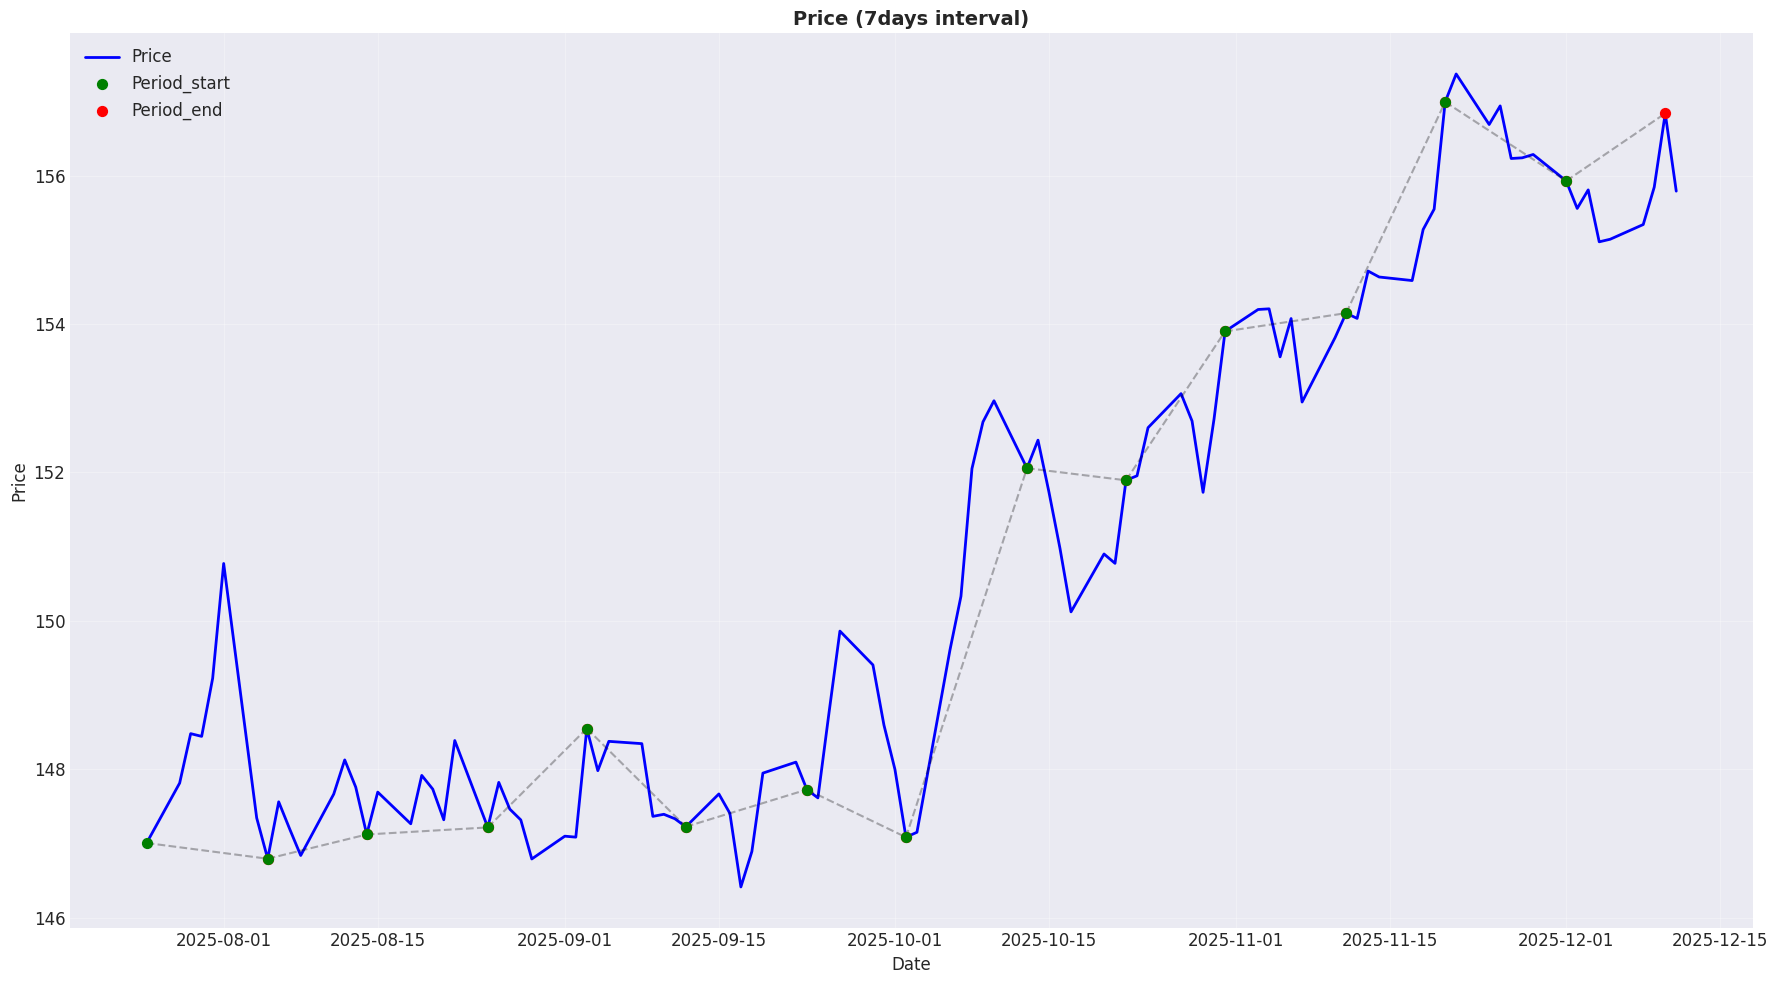

In [18]:
fig, ax = plt.subplots(figsize=(18, 10))

recent = df.tail(100)
ax.plot(
    recent.index,
    recent['Close'],
    label = 'Price', 
    linewidth=2, 
    color='blue'
    )

for i in range(0, len(recent), 7): 
    if i + 7 < len(recent): 
        ax.scatter(recent.index[i], recent['Close'].iloc[i],
                color='green', s=50, zorder=5)
        ax.scatter(recent.index[i+7], recent['Close'].iloc[i+7], 
                color='red', s=50, zorder=5)
        ax.plot([recent.index[i], recent.index[i+7]], 
                [recent['Close'].iloc[i], recent['Close'].iloc[i+7]], 
                'k--', alpha=0.3)
ax.set_title('Price (7days interval)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend(['Price', 'Period_start', 'Period_end'])
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

<center><font centor size = 8 color='green'>7-day returns

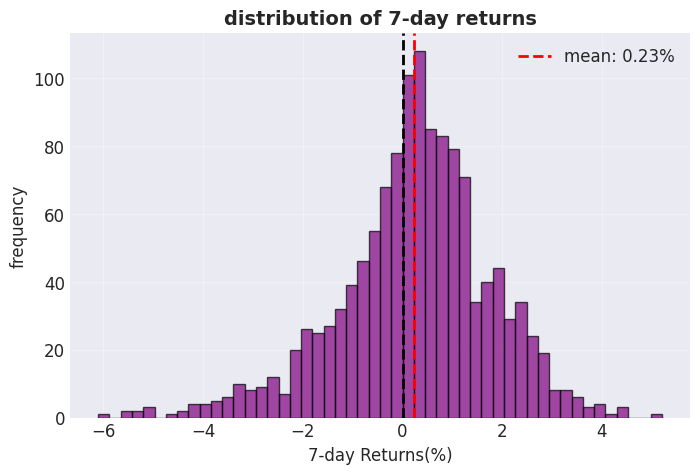

In [19]:
fig, ax = plt.subplots(figsize=[8, 5])
ax.hist(df['Future_Return_7d'] * 100, bins=50, alpha=0.7, 
        color='purple', edgecolor='black')

ax.axvline(x=0, color='black', linestyle='--', linewidth=2)
ax.axvline(x=df['Future_Return_7d'].mean() * 100,
        color='red', 
        linestyle='--', 
        linewidth=2,
        label=f'mean: {df["Future_Return_7d"].mean()*100:.2f}%')
ax.set_title('distribution of 7-day returns',
        fontsize=14, 
        fontweight='bold')
ax.set_xlabel('7-day Returns(%)')
ax.set_ylabel('frequency')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()


<font color='green' size=4>I think that an average yield of 2% over a 7-day period is a very good result. I need to research it further, but for now, everything is leading to the fact that we can get 2% on a deposit within a week.

<center><font center size = 5 color='red'>

<center><font center size=5 color='red'>Class counts

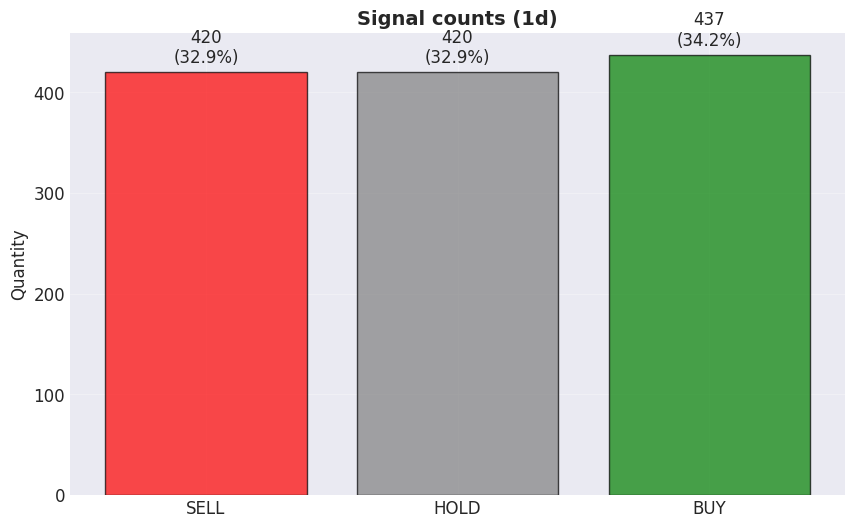

In [20]:
fig, ax = plt.subplots(figsize=[10, 6])

clas_counts = df['Target_Class'].value_counts().sort_index()
colors = ['red', 'gray', 'green']
labels = ['SELL', 'HOLD', 'BUY']

bars = ax.bar(labels, class_counts.values, color=colors, alpha=0.7, edgecolor='black')
ax.set_title('Signal counts (1d)', fontsize=14, fontweight='bold')
ax.set_ylabel('Quantity')

for bar, count in zip(bars, class_counts.values): 
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 5, 
            f'{count}\n({count/len(df):.1%})', 
            ha='center', va='bottom')
ax.grid(True, alpha=0.3)
plt.show()

<font center size=6 color="red">Features Correlation 

<Axes: xlabel='Price-Ticker', ylabel='Price-Ticker'>

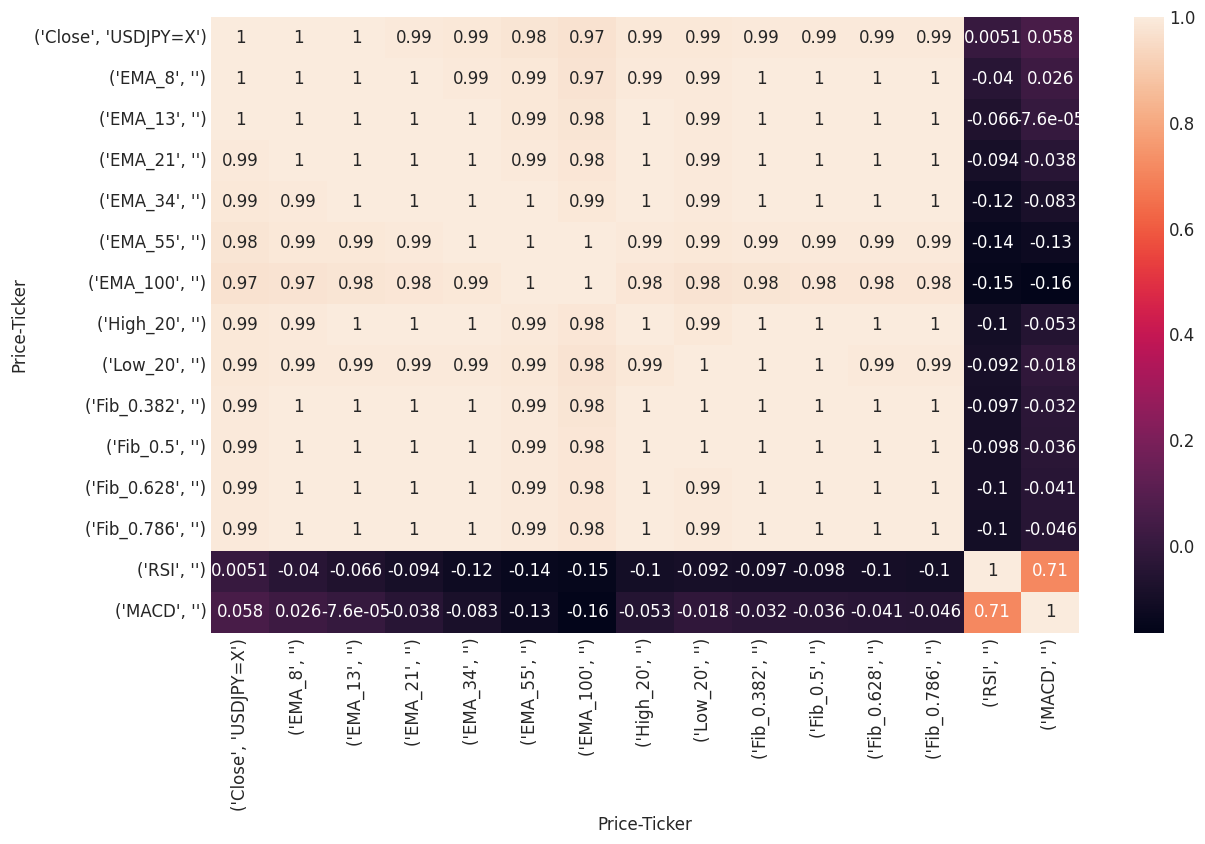

In [21]:
corr_features = ['Close', 'EMA_8', 'EMA_13', 
                'EMA_21', 'EMA_34', 'EMA_55', 
                'EMA_100', 'High_20', 'Low_20',
                'Fib_0.382', 'Fib_0.5', 'Fib_0.628', 
                'Fib_0.786', 'RSI', 'MACD']
corr = df[corr_features].corr()

sns.heatmap( 
    corr, 
    annot= True, 
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values
)

<center><font center size=6 color='red'> Model Prepare

In [22]:
def prepare_model_data_7day(df, seq_length=30):

    feature_cols = [
      'Close', 'EMA_8', 'EMA_13', 'EMA_21', 
      'EMA_34', 'EMA_55', 'EMA_100', 
      'MACD_signal',	'MACD_diff',	'Returns',	
      'DayOfWeek',	'Month',	'WeekOfYear', 
      'Future_Price_7d',	'Future_Return_7d',
      'RSI', 'MACD', 'High_20', 'Low_20', 
      'Fib_0.236', 'Fib_0.382', 'Fib_0.5', 
      'Fib_0.628', 'Fib_0.786' 
    ]

    available_cols = [col for col in feature_cols if col in df.columns]
    print('use ', len(available_cols), ' features')

    X = df[available_cols].values
    y_class = df['Target_Class'].values + 1 # Change -1,0,1 to 0,1,2
    y_reg = df['Target_Reg'].values #Price then 7-day

    print('Size X: ', X.shape)
    print('Size y_class: ', y_class.shape)
    print('Size y_reg: ', y_reg.shape)

    # TimeSeries think train/test split
    split_idx = int(len(X) * 0.8)

    X_train = X[:split_idx]
    X_test = X[split_idx:]

    y_class_train = y_class[:split_idx]
    y_class_test = y_class[split_idx:]

    y_reg_train = y_reg[:split_idx]
    y_reg_test = y_reg[split_idx:]

    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.fit_transform(X_test)

    scaler_y = StandardScaler()
    y_reg_train_scaled = scaler_y.fit_transform(y_reg_train.reshape(-1, 1)).flatten()
    y_reg_test_scaled = scaler_y.transform(y_reg_test.reshape(-1, 1)).flatten()


    #For lstm 
    X_train_seq, y_class_train_seq, y_reg_train_seq = [], [], []
    X_test_seq, y_class_test_seq, y_reg_test_seq = [], [], []

    scaler_lstm_X = MinMaxScaler()
    scaler_lstm_y = MinMaxScaler()

    X_scaled_all = scaler_lstm_X.fit_transform(X)
    y_reg_scaled_all = scaler_lstm_y.fit_transform(y_reg.reshape(-1, 1)).flatten()

    for i in range(seq_length, split_idx): 
      X_train_seq.append(X_scaled_all[i-seq_length:i])
      y_class_train_seq.append(y_class[i])
      y_reg_train_seq.append(y_reg_scaled_all[i])

    for i in range(split_idx + seq_length, len(X_scaled_all)): 
      X_test_seq.append(X_scaled_all[i-seq_length:i])
      y_class_test_seq.append(y_class[i])
      y_reg_test_seq.append(y_reg_scaled_all[i])

    X_train_seq = np.array(X_train_seq)
    X_test_seq = np.array(X_test_seq)

    y_class_train_seq = np.array(y_class_train_seq)
    y_class_test_seq = np.array(y_class_test_seq)

    y_reg_train_seq = np.array(y_reg_train_seq)
    y_reg_test_seq = np.array(y_reg_test_seq)

    print("Sizes for LSTM: ")
    print("X_train_seq: ", X_train_seq.shape)
    print('X_test_seq: ', X_test_seq.shape)

    return {
    # Для традиционных моделей
    'X_train': X_train_scaled, 'X_test': X_test_scaled,
    'y_class_train': y_class_train, 'y_class_test': y_class_test,
    'y_reg_train': y_reg_train_scaled, 'y_reg_test': y_reg_test_scaled,
    'y_reg_original_train': y_reg_train, 'y_reg_original_test': y_reg_test,

    # Для LSTM
    'X_train_seq': X_train_seq, 'X_test_seq': X_test_seq,
    'y_class_train_seq': y_class_train_seq, 'y_class_test_seq': y_class_test_seq,
    'y_reg_train_seq': y_reg_train_seq, 'y_reg_test_seq': y_reg_test_seq,

    # Скалеры
    'scaler_X': scaler_X,
    'scaler_y': scaler_y,
    'scaler_lstm_X': scaler_lstm_X,
    'scaler_lstm_y': scaler_lstm_y,

    'feature_cols': available_cols,
    'seq_length': seq_length
    }

In [23]:
df_dict = prepare_model_data_7day(df, seq_length=30)

use  24  features
Size X:  (1277, 24)
Size y_class:  (1277,)
Size y_reg:  (1277,)
Sizes for LSTM: 
X_train_seq:  (991, 30, 24)
X_test_seq:  (226, 30, 24)


In [24]:
models = {}
results = {}

In [25]:
#RF classific. 
rf_classifier = RandomForestClassifier( 
    n_estimators = 100, 
    max_depth = 10, 
    random_state = 42, 
    n_jobs=-1
)

rf_classifier.fit(df_dict["X_train"], df_dict['y_class_train'])
y_pred = rf_classifier.predict(df_dict['X_test'])
accuracy = accuracy_score(df_dict['y_class_test'], y_pred)

models['random_forest'] = rf_classifier
results['random_forest'] = { 
    'accuracy': accuracy, 
    'predictions': y_pred, 
    'model': rf_classifier
}
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.832
